In [129]:
import os

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.21.0-dev20251017
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [130]:
#imports
import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [131]:
#directories
base_dir = '' 
train_dir = os.path.join(base_dir,'/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train/') 

In [ ]:
batch_size = 64
val_size = 0.2


MAX_SIZE = 128  #max height or width

def resize_keep_aspect(img):
    h, w = img.shape[:2]
    scale = MAX_SIZE / max(h, w)
    if scale < 1:
        new_w, new_h = int(w * scale), int(h * scale)
        img = tf.image.resize(img, (new_h, new_w), method='lanczos3')
    return img

train_data_gen = ImageDataGenerator(rescale=1./127,validation_split= 0.2)
val_data_gen = ImageDataGenerator(rescale=1./127,validation_split=0.2)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (MAX_SIZE, MAX_SIZE),
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training',
                                                     color_mode='grayscale'
                                                     )

val_generator =  train_data_gen.flow_from_directory(train_dir,
                                               target_size = (MAX_SIZE, MAX_SIZE),
                                               batch_size = batch_size,
                                               seed=42, 
                                               shuffle=True,
                                               subset='validation',
                                               color_mode='grayscale')

print("Detected classes:", train_generator.class_indices)


# #random data changes for better generalizing
# train_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.2,
#     brightness_range=[0.7, 1.3],
#     horizontal_flip=True
# )

# val_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
# )

# #training params
# train_generator = train_data_gen.flow_from_directory(
#     train_dir,
#     batch_size=batch_size,
#     seed=42,
#     shuffle=True,
#     subset='training',
#     color_mode='grayscale',
#     class_mode='categorical',
#     target_size=(MAX_SIZE, MAX_SIZE)
# )

# val_generator = val_data_gen.flow_from_directory(
#     train_dir,
#     target_size=(MAX_SIZE, MAX_SIZE),
#     batch_size=batch_size,
#     seed=42,
#     shuffle=False,
#     subset='validation',
#     color_mode='grayscale',
#     class_mode='categorical',
# )


TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'color_mode'

In [ ]:
#debug count data
import collections

class_counts = collections.Counter(train_generator.classes)
for cls, count in class_counts.items():
    print(f"{cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")

0 (c0): 3471
1 (c1): 20209
2 (c2): 1183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07086614..2.007874].


(64, 128, 128, 3)
(64, 3)
(64, 128, 128, 3) 0.0 2.007874


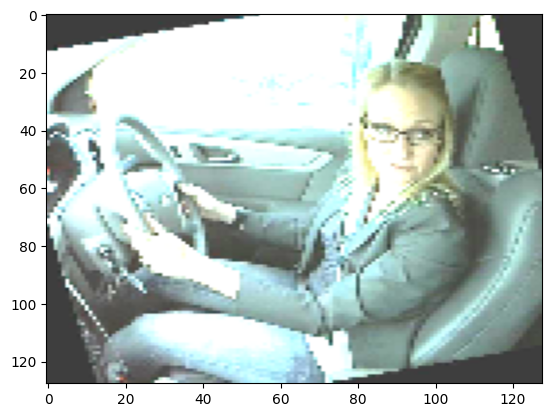

In [ ]:
for data_batch,label_batch in train_generator:
    print(data_batch.shape) 
    print(label_batch.shape) 
    break

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_x.min(), batch_x.max())
plt.imshow(np.squeeze(batch_x[0]), cmap='gray', aspect='auto')
plt.show()

In [ ]:
#cpu handle random dropout cuz issue with CUDA
import tensorflow as tf
from keras.layers import Dropout

class CPUDropout(Dropout):
    def call(self, inputs, training=None):
        with tf.device('/CPU:0'):
            return super().call(inputs, training=training)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf

model = Sequential()                                                  # creating a sequential model
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,1))) # taking units of 32 and filter of 3x3
model.add(MaxPooling2D(2,2))                                          # maxpool layer with 2x2 filter   
model.add(Conv2D(64,(3,3),activation='relu'))                         # taking units of 64 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))                        # taking units of 128 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))                        # taking units of 256 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512,(3,3),activation='relu'))                        # taking units of 512 and filter of 3x3
model.add(MaxPooling2D(2,2))    
model.add(Flatten())                                                  # flattening the data to feed into to Dense layer
model.add(Dense(1024,activation='relu'))                              # taking units of 1024
model.add(Dense(512,activation='relu'))                               # taking units of 512 
model.add(Dense(128,activation='relu'))                               # taking units of 128
model.add(Dense(3,activation='softmax'))                             # output later with units of 10 since 10 labels

model.summary() # to print summary of model architecture

model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

# #convert grayscale
# def to_rgb(x):
#     return tf.image.grayscale_to_rgb(x)

# #use mobilenet, transfer learning
# inputs = Input(shape=(None, None, 1)) 
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# base_model = MobileNetV2(
#     input_shape=(None, None, 3),
#     include_top=False,
#     weights='imagenet'
# )

# #unfreeze last 15 layers
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# #custom classifier
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# x = base_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.65)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = Dropout(0.5)(x)
# outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# model = Model(inputs, outputs)

# #yay
# model.compile(
#     optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-4),
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#     metrics=['accuracy']
# )

# model.summary()


/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,257,603 (16.24 MB)

 Trainable params: 4,257,603 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#autocalculate class weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices
num_classes = len(class_indices)
class_labels = np.unique(train_generator.classes)

weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_generator.classes
)

class_weights = dict(enumerate(weights))

print("\nAuto-calculated class weights:")
for i, w in class_weights.items():
    class_name = list(class_indices.keys())[i]
    print(f"  {i} ({class_name}): {w:.3f}")

# manual weights just in case
# class_weights = {
#     0: 1.2,  #Safe driving
#     1: 0.7,  #distracted
#     2: 0.1,  #tired
# }


Auto-calculated class weights:
  0 (c0): 2.388
  1 (c1): 0.410
  2 (c2): 7.006


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#stop training if too much loss or plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)  

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

#start training
# history = model.fit(
#     train_generator,
#     epochs=15,
#     validation_data=val_generator,
#     class_weight=class_weights,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=callbacks
# )

/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.8762 - loss: 0.3479 - val_accuracy: 0.9015 - val_loss: 0.7576
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9578 - loss: 0.1359 - val_accuracy: 0.9252 - val_loss: 0.7687
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9690 - loss: 0.1036 - val_accuracy: 0.9181 - val_loss: 0.6710
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9753 - loss: 0.0819 - val_accuracy: 0.9308 - val_loss: 0.5902
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9783 - loss: 0.0721 - val_accuracy: 0.9305 - val_loss: 0.6273
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9823 - loss: 0.0619 - val_accuracy: 0.9257 - val_loss: 0.8918
Epoch 7/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9833 - loss: 0.0563 - val_accuracy: 0.9306 - val_loss: 1.1437
Epoch 8/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9847 - loss: 0.0501 - 

In [ ]:
model.save("distracted_driver_detection.keras")

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step
              precision    recall  f1-score   support

          c0       0.13      0.12      0.12       867
          c1       0.81      0.79      0.80      5052
          c2       0.05      0.09      0.06       295

    accuracy                           0.67      6214
   macro avg       0.33      0.33      0.33      6214
weighted avg       0.68      0.67      0.67      6214



In [ ]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

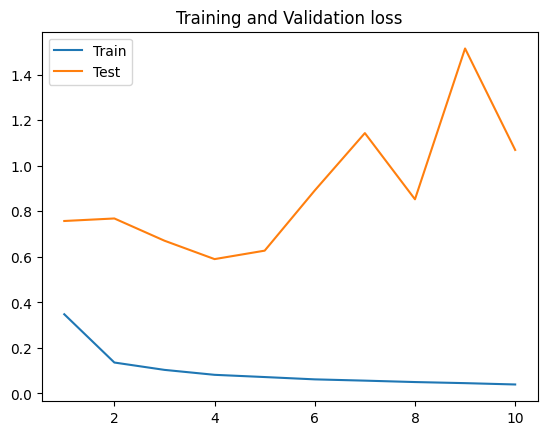

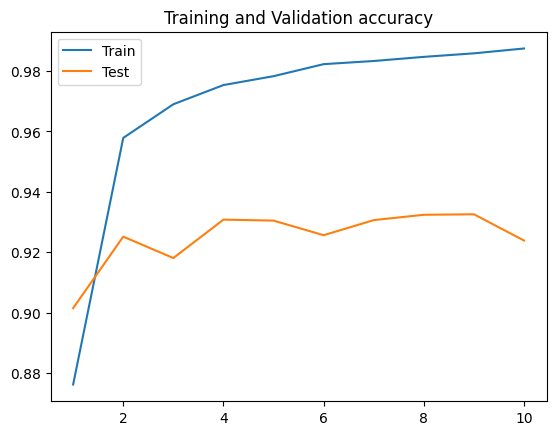

In [ ]:
#graph training results
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

In [ ]:
# test model with real data and show results
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import math

def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

model = load_model("distracted_driver_detection.keras",
    custom_objects={
        "CPUDropout": Dropout,
        "to_rgb": to_rgb
    })

class_names = ["Safe driving", "Distracted", "Tired"]

folder = "/home/lurpd/Development/Datasets/MyData/"
target_size=(MAX_SIZE, MAX_SIZE)

image_paths = []
for i in range(30, 63):
    for ext in [".png", ".PNG", ".jpg", ".JPG", ".jpeg", ".JPEG"]:
        candidate = os.path.join(folder, f"{i}{ext}")
        if os.path.exists(candidate):
            image_paths.append(candidate)
            break  

cols = 8
rows = math.ceil(len(image_paths) / cols)
max_width_px = 2500
max_height_px = 1300
dpi = 100
fig_width = min(max_width_px / dpi, cols * 3)
fig_height = min(max_height_px / dpi, rows * 3)
plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

for idx, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("L")
    img.thumbnail((256, 256), Image.Resampling.LANCZOS)
    img_array = np.expand_dims(np.array(img).astype(np.float32) / 255.0, axis=(0, -1))

    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(np.squeeze(img), cmap='gray', aspect='auto')
    plt.axis("off")
    plt.text(
        0.5, -0.05,
        f"{os.path.basename(img_path)}\n{predicted_label} ({confidence:.1f}%)",
        fontsize=9,
        ha="center", va="top",
        transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.draw()

output_path = "predictions_grid.png"
plt.savefig(output_path, dpi=150, bbox_inches="tight")
print(f"Saved predictions grid to {output_path}")

try:
    if os.path.exists("/mnt/c/Windows"):
        os.system(f"explorer.exe {output_path.replace('/', '\\\\')}")
    else:
        os.system(f"xdg-open {output_path}")
except Exception as e:
    print(f"Could not auto-open image: {e}")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_20" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 256, 147, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 256, 147, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

<Figure size 2400x1300 with 0 Axes>